In [1]:
import tensorflow as tf
import utils as u
import h5py
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import os
import numpy as np
import random as rn


from sklearn.metrics import roc_curve,roc_auc_score,auc
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn import metrics

%matplotlib inline
import itertools

import keras 
from keras.models import load_model
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras import backend as K
from keras.layers import Dense, Dropout, Flatten,Conv2D, MaxPooling2D,Activation,BatchNormalization,LeakyReLU
from keras.utils import to_categorical,plot_model
from keras.models import Sequential
from keras.optimizers import Adam

Using TensorFlow backend.


In [2]:
#for reproducibility in Python,numpy and Tensorflow we set their respective seeds as follows
os.environ['PYTHONHASHSEED']='0'
np.random.seed(None) ##don't want to seed numpy with random sized hot/dead regions
rn.seed(2)
tf.set_random_seed(3)
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)

#Force Tensorflow to use a single thread (this is recommended because it might be a cause of randomness)
sess=tf.Session(graph=tf.get_default_graph(),config=session_conf)
K.set_session(sess)

In [3]:
data_folder = '../../data'
file_name = 'HCAL_digi+rechit_occ.hdf5'
group = 'DigiTask_Occupancy_depth_depth1'

runs = ['306459','306138','306139']

data_sample= np.empty([0,72,84])
for run in runs:
    input_file=h5py.File(data_folder+'/'+'HCAL_digi+rechit_occ_run'+run+'.hdf5','r+')
    data_sample = np.concatenate((data_sample,np.array(input_file[group])),axis=0)
    
print data_sample.shape

data_sample=data_sample[:,:,26:58]

print data_sample.shape

average_occ = np.average(data_sample)

print average_occ

for i in range(data_sample.shape[0]):
    for j in range(data_sample.shape[1]):
        for k in range(data_sample.shape[2]):
            if data_sample[i][j][k] == 0.0:
                #print 'yo', i, j, k
                data_sample[i][j][k] = average_occ
                

(2997, 72, 84)
(2997, 72, 32)
567.190321398


Shape of regular image is:  (2997, 72, 32)
Shape of dead image is:  (1506, 72, 32)
Shape of hot image is:  (1491, 72, 32)



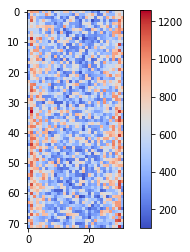

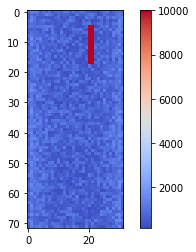

In [4]:
input_images=data_sample[:]
hotregion_image=[]
deadregion_image=[]

for k in input_images:
    
    yn = np.random.randint(2)
    
    xLen = np.random.randint(1,17)
    yLen = np.random.randint(1,17)
    
    a=np.random.randint(input_images.shape[2]-xLen)
    b=np.random.randint(input_images.shape[1]-yLen)
    
    xdim=(a,a+xLen)
    ydim=(b,b+yLen)
    
    #print 'xdim =', xdim
    #print 'ydim =', ydim
    
    if yn == 1:
        hotregion_image.append( u.hotregion(k,xdim,ydim))
    else:
        deadregion_image.append(u.killregion(k,xdim,ydim))
       
    
hotregion_image=np.array(hotregion_image)
deadregion_image=np.array(deadregion_image)

print "Shape of regular image is: ",input_images.shape
print "Shape of dead image is: " ,deadregion_image.shape
print "Shape of hot image is: " ,hotregion_image.shape

print ''
im=plt.imshow(input_images[1],cmap=cm.coolwarm)
plt.colorbar()
plt.show()
plt.clf()


im=plt.imshow(hotregion_image[1],cmap=cm.coolwarm)
plt.colorbar()
plt.show()
plt.clf()#plt.clf clears the figure and it's axis but leaves the window open. 
         #as opposed to plt.close which closes the window. If you are showing many images at a time without
         #closing the window it is better.

#input_image=np.reshape(input_image,(input_image.shape[0],input_image.shape[1]))


In [5]:
sample= np.append(data_sample,hotregion_image,axis=0)
sample= np.append(sample,deadregion_image,axis=0)
print sample.shape

(5994, 72, 32)


In [6]:
X=np.copy(sample)

y=np.zeros((sample.shape[0],1))
k=0
for img in X:
    X[k] = X[k] / np.max(img)
    k=k+1
#print y.shape
#print input_images.shape[0]


#this is because I am only going to add the hot and dead region images

### Changed this to a 2 class problem, good and bad
y[-1*input_images.shape[0]:]=1
#if you want it as integers leave this as it is
#if you would like it as a vector then do this

y=to_categorical(y,2)

# convert class vectors to binary class matrices
#y_train = keras.utils.to_categorical(y_train, num_classes)
#y_test = keras.utils.to_categorical(y_test, num_classes)

print "X shape is: ",X.shape
print "y shape is: ",y.shape
# input image dimensions
img_rows, img_cols = X.shape[1],X.shape[2]

X shape is:  (5994, 72, 32)
y shape is:  (5994, 2)


Xtrain.shape (3596, 72, 32)
Xtest.shape (2398, 72, 32)
ytrain.shape (3596, 2)
ytest.shape (2398, 2)
Printing labels and their corresponding images
-------------------
[ 0.  1.]


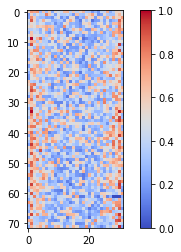

-------------------
[ 0.  1.]


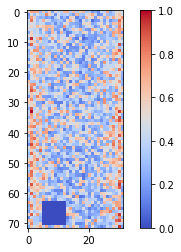

-------------------
[ 0.  1.]


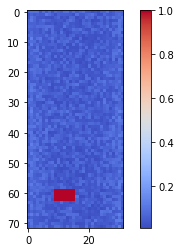

-------------------
[ 0.  1.]


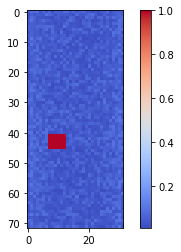

-------------------
[ 0.  1.]


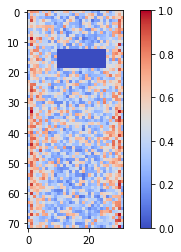

-------------------
[ 1.  0.]


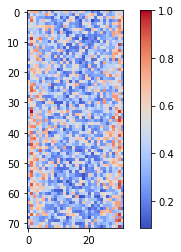

-------------------
[ 0.  1.]


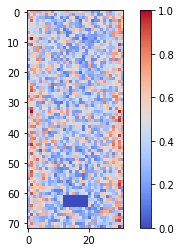

-------------------
[ 1.  0.]


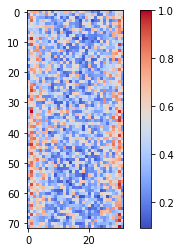

-------------------
[ 0.  1.]


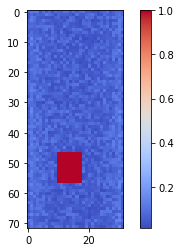

-------------------
[ 0.  1.]


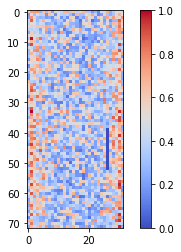

Xtrain.shape after if statement (3596, 72, 32, 1)
Xtest.shape after if statement (2398, 72, 32, 1)
ytrain.shape after if statement (3596, 2)
ytest.shape after if statement (2398, 2)


In [7]:
Xtrain, Xtest ,ytrain, ytest =train_test_split(X,y,test_size=.4,random_state =5 )

print 'Xtrain.shape',Xtrain.shape
print 'Xtest.shape',Xtest.shape
print 'ytrain.shape',ytrain.shape
print 'ytest.shape',ytest.shape
print 'Printing labels and their corresponding images'
    
for k in range(10):
    print'-------------------'
    print ytrain[k]
    im=plt.imshow(Xtrain[k],cmap=cm.coolwarm)
    plt.colorbar()
    plt.show()
    plt.clf()


Xtrain, Xtest,input_shape= u.check_test_and_train_images_format(Xtrain, Xtest, img_rows, img_cols)

print 'Xtrain.shape after if statement',Xtrain.shape
print 'Xtest.shape after if statement',Xtest.shape
print 'ytrain.shape after if statement',ytrain.shape
print 'ytest.shape after if statement',ytest.shape
    

In [8]:
"""A Custom Loss Function"""

#### [0.1,0.9] works well (acc > 0.99) but still no movement across the diagonal

x = np.array([[0.1,0.9]])
w = K.variable(x, name='w')

def customLoss(yTrue,yPred):
    return K.sum(K.dot(w, K.transpose(K.square(yTrue - yPred))))

In [9]:
"""this is the dummy model"""
#model = Sequential()

#model.add(Conv2D(10, kernel_size=(2, 2), strides=(1, 1),input_shape=input_shape))
#model.add(BatchNormalization())
#model.add(Activation('relu'))
#model.add(MaxPooling2D(pool_size=(2,2)))

#model.add(Conv2D(8, kernel_size=(3, 3),strides=(1, 1)))
#model.add(BatchNormalization())
#model.add(Activation('relu'))
#model.add(MaxPooling2D(pool_size=(2,2)))

#model.add(Conv2D(8,kernel_size=(1,1)))
#model.add(BatchNormalization())
#model.add(Activation('relu'))
#
#model.add(Dropout(0.25))
#model.add(Flatten())

#model.add(Dense(8))
#model.add(BatchNormalization())
#model.add(Activation('relu'))

##Last layer is Dense (as usual), note output size (first arg) is label size
#model.add(Dense(2, activation='softmax'))


#model.compile(loss='categorical_crossentropy',
#              optimizer='Nadam',#Adam(lr=1e-3),
#              metrics=['accuracy'])
#model.summary()
#plot_model(model, to_file='Supervised_model.png',)
#
#model.save('emptymodel.hdf5')

"""This is a more minimal model"""

model = Sequential()

model.add(Conv2D(5, kernel_size=(3, 3), strides=(1, 1),input_shape=input_shape))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(3,3)))

model.add(Dropout(0.25))
model.add(Flatten())

#Last layer is Dense (as usual), note output size (first arg) is label size
model.add(Dense(2, activation='softmax'))


model.compile(loss=customLoss,
              optimizer='Nadam',#Adam(lr=1e-3),
              metrics=['accuracy'])

model.summary()
plot_model(model, to_file='Supervised_model.png',)

model.save('emptymodel.hdf5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 70, 30, 5)         50        
_________________________________________________________________
batch_normalization_1 (Batch (None, 70, 30, 5)         20        
_________________________________________________________________
activation_1 (Activation)    (None, 70, 30, 5)         0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 10, 5)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 23, 10, 5)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1150)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 2302      
Total para

In [10]:
checkpointer = ModelCheckpoint(filepath='best_nbmodel_good_bad.hdf5', verbose=2, save_best_only=True)
earlystop= EarlyStopping(monitor='val_loss', min_delta=0, patience=50, verbose=1, mode='auto')

In [11]:
history = model.fit(Xtrain,ytrain,epochs=400
                    ,verbose=2
                    ,validation_data=(Xtest,ytest)
                    ,shuffle=True
                    ,callbacks=[checkpointer,earlystop])

Train on 3596 samples, validate on 2398 samples
Epoch 1/400
Epoch 00001: val_loss improved from inf to 7.23917, saving model to best_nbmodel_good_bad.hdf5
 - 25s - loss: 9.3675 - acc: 0.6555 - val_loss: 7.2392 - val_acc: 0.7269
Epoch 2/400
Epoch 00002: val_loss did not improve
 - 26s - loss: 8.4325 - acc: 0.7072 - val_loss: 7.8868 - val_acc: 0.7335
Epoch 3/400
Epoch 00003: val_loss did not improve
 - 27s - loss: 8.1984 - acc: 0.7144 - val_loss: 8.6382 - val_acc: 0.7331
Epoch 4/400
Epoch 00004: val_loss improved from 7.23917 to 5.61628, saving model to best_nbmodel_good_bad.hdf5
 - 27s - loss: 7.8603 - acc: 0.7272 - val_loss: 5.6163 - val_acc: 0.7460
Epoch 5/400
Epoch 00005: val_loss improved from 5.61628 to 5.55689, saving model to best_nbmodel_good_bad.hdf5
 - 25s - loss: 5.7192 - acc: 0.7517 - val_loss: 5.5569 - val_acc: 0.7469
Epoch 6/400
Epoch 00006: val_loss improved from 5.55689 to 4.04448, saving model to best_nbmodel_good_bad.hdf5
 - 25s - loss: 4.4332 - acc: 0.8098 - val_loss:

Epoch 54/400
Epoch 00054: val_loss did not improve
 - 24s - loss: 1.2752 - acc: 0.9544 - val_loss: 1.1328 - val_acc: 0.9537
Epoch 55/400
Epoch 00055: val_loss did not improve
 - 26s - loss: 1.2822 - acc: 0.9508 - val_loss: 1.1804 - val_acc: 0.9600
Epoch 56/400
Epoch 00056: val_loss did not improve
 - 26s - loss: 1.1867 - acc: 0.9561 - val_loss: 1.1123 - val_acc: 0.9658
Epoch 57/400
Epoch 00057: val_loss did not improve
 - 24s - loss: 1.2372 - acc: 0.9552 - val_loss: 1.1662 - val_acc: 0.9608
Epoch 58/400
Epoch 00058: val_loss did not improve
 - 24s - loss: 1.3401 - acc: 0.9522 - val_loss: 1.1698 - val_acc: 0.9525
Epoch 59/400
Epoch 00059: val_loss did not improve
 - 23s - loss: 1.1771 - acc: 0.9588 - val_loss: 1.1290 - val_acc: 0.9558
Epoch 60/400
Epoch 00060: val_loss did not improve
 - 25s - loss: 1.1266 - acc: 0.9591 - val_loss: 1.0478 - val_acc: 0.9616
Epoch 61/400
Epoch 00061: val_loss did not improve
 - 24s - loss: 1.1164 - acc: 0.9594 - val_loss: 1.0529 - val_acc: 0.9595
Epoch 62

Epoch 115/400
Epoch 00115: val_loss did not improve
 - 23s - loss: 0.7217 - acc: 0.9750 - val_loss: 0.5922 - val_acc: 0.9791
Epoch 116/400
Epoch 00116: val_loss improved from 0.56572 to 0.55305, saving model to best_nbmodel_good_bad.hdf5
 - 24s - loss: 0.5269 - acc: 0.9828 - val_loss: 0.5530 - val_acc: 0.9800
Epoch 117/400
Epoch 00117: val_loss did not improve
 - 23s - loss: 0.5379 - acc: 0.9814 - val_loss: 0.5764 - val_acc: 0.9800
Epoch 118/400
Epoch 00118: val_loss improved from 0.55305 to 0.55264, saving model to best_nbmodel_good_bad.hdf5
 - 23s - loss: 0.6895 - acc: 0.9775 - val_loss: 0.5526 - val_acc: 0.9800
Epoch 119/400
Epoch 00119: val_loss did not improve
 - 24s - loss: 0.5250 - acc: 0.9814 - val_loss: 0.8257 - val_acc: 0.9796
Epoch 120/400
Epoch 00120: val_loss did not improve
 - 23s - loss: 0.6129 - acc: 0.9783 - val_loss: 0.5879 - val_acc: 0.9800
Epoch 121/400
Epoch 00121: val_loss did not improve
 - 23s - loss: 0.5716 - acc: 0.9803 - val_loss: 0.5693 - val_acc: 0.9796
Epo

Epoch 176/400
Epoch 00176: val_loss did not improve
 - 24s - loss: 0.3756 - acc: 0.9878 - val_loss: 0.4135 - val_acc: 0.9837
Epoch 177/400
Epoch 00177: val_loss did not improve
 - 25s - loss: 0.4991 - acc: 0.9828 - val_loss: 0.4935 - val_acc: 0.9812
Epoch 178/400
Epoch 00178: val_loss did not improve
 - 24s - loss: 0.3946 - acc: 0.9867 - val_loss: 0.4557 - val_acc: 0.9825
Epoch 179/400
Epoch 00179: val_loss did not improve
 - 24s - loss: 0.3471 - acc: 0.9878 - val_loss: 0.4248 - val_acc: 0.9842
Epoch 180/400
Epoch 00180: val_loss did not improve
 - 24s - loss: 0.3269 - acc: 0.9892 - val_loss: 0.4152 - val_acc: 0.9846
Epoch 181/400
Epoch 00181: val_loss did not improve
 - 25s - loss: 0.4444 - acc: 0.9844 - val_loss: 0.4615 - val_acc: 0.9829
Epoch 182/400
Epoch 00182: val_loss did not improve
 - 24s - loss: 0.3723 - acc: 0.9867 - val_loss: 0.4512 - val_acc: 0.9842
Epoch 183/400
Epoch 00183: val_loss did not improve
 - 24s - loss: 0.3952 - acc: 0.9864 - val_loss: 0.4280 - val_acc: 0.9837


Epoch 238/400
Epoch 00238: val_loss did not improve
 - 25s - loss: 0.3029 - acc: 0.9894 - val_loss: 0.3854 - val_acc: 0.9850
Epoch 239/400
Epoch 00239: val_loss did not improve
 - 23s - loss: 0.2380 - acc: 0.9925 - val_loss: 0.3328 - val_acc: 0.9875
Epoch 240/400
Epoch 00240: val_loss did not improve
 - 23s - loss: 0.2381 - acc: 0.9922 - val_loss: 0.3370 - val_acc: 0.9875
Epoch 241/400
Epoch 00241: val_loss did not improve
 - 24s - loss: 0.2458 - acc: 0.9919 - val_loss: 0.3354 - val_acc: 0.9871
Epoch 242/400
Epoch 00242: val_loss improved from 0.31228 to 0.31113, saving model to best_nbmodel_good_bad.hdf5
 - 23s - loss: 0.2673 - acc: 0.9908 - val_loss: 0.3111 - val_acc: 0.9871
Epoch 243/400
Epoch 00243: val_loss did not improve
 - 23s - loss: 0.2695 - acc: 0.9903 - val_loss: 0.4088 - val_acc: 0.9850
Epoch 244/400
Epoch 00244: val_loss did not improve
 - 23s - loss: 0.3508 - acc: 0.9878 - val_loss: 0.4296 - val_acc: 0.9846
Epoch 245/400
Epoch 00245: val_loss did not improve
 - 23s - los

Epoch 300/400
Epoch 00300: val_loss improved from 0.26128 to 0.25419, saving model to best_nbmodel_good_bad.hdf5
 - 23s - loss: 0.1643 - acc: 0.9944 - val_loss: 0.2542 - val_acc: 0.9904
Epoch 301/400
Epoch 00301: val_loss did not improve
 - 23s - loss: 0.1721 - acc: 0.9944 - val_loss: 0.2746 - val_acc: 0.9900
Epoch 302/400
Epoch 00302: val_loss improved from 0.25419 to 0.24398, saving model to best_nbmodel_good_bad.hdf5
 - 23s - loss: 0.2312 - acc: 0.9925 - val_loss: 0.2440 - val_acc: 0.9904
Epoch 303/400
Epoch 00303: val_loss did not improve
 - 23s - loss: 0.1534 - acc: 0.9947 - val_loss: 0.2571 - val_acc: 0.9904
Epoch 304/400
Epoch 00304: val_loss did not improve
 - 23s - loss: 0.1522 - acc: 0.9950 - val_loss: 0.2492 - val_acc: 0.9904
Epoch 305/400
Epoch 00305: val_loss improved from 0.24398 to 0.23602, saving model to best_nbmodel_good_bad.hdf5
 - 24s - loss: 0.1955 - acc: 0.9936 - val_loss: 0.2360 - val_acc: 0.9904
Epoch 306/400
Epoch 00306: val_loss improved from 0.23602 to 0.2324

Epoch 361/400
Epoch 00361: val_loss did not improve
 - 21s - loss: 0.1237 - acc: 0.9958 - val_loss: 0.2510 - val_acc: 0.9896
Epoch 362/400
Epoch 00362: val_loss did not improve
 - 22s - loss: 0.1870 - acc: 0.9939 - val_loss: 0.2247 - val_acc: 0.9925
Epoch 363/400
Epoch 00363: val_loss did not improve
 - 21s - loss: 0.1602 - acc: 0.9947 - val_loss: 0.2236 - val_acc: 0.9908
Epoch 364/400
Epoch 00364: val_loss did not improve
 - 21s - loss: 0.1048 - acc: 0.9969 - val_loss: 0.2301 - val_acc: 0.9904
Epoch 365/400
Epoch 00365: val_loss did not improve
 - 21s - loss: 0.1387 - acc: 0.9958 - val_loss: 0.2143 - val_acc: 0.9912
Epoch 366/400
Epoch 00366: val_loss did not improve
 - 21s - loss: 0.0825 - acc: 0.9972 - val_loss: 0.2215 - val_acc: 0.9912
Epoch 367/400
Epoch 00367: val_loss did not improve
 - 21s - loss: 0.1226 - acc: 0.9956 - val_loss: 0.2084 - val_acc: 0.9921
Epoch 368/400
Epoch 00368: val_loss improved from 0.20556 to 0.20516, saving model to best_nbmodel_good_bad.hdf5
 - 22s - los

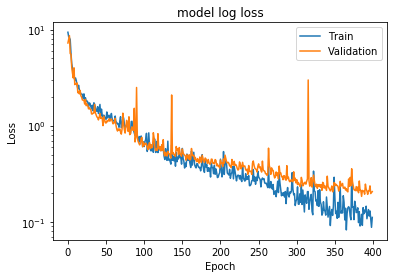

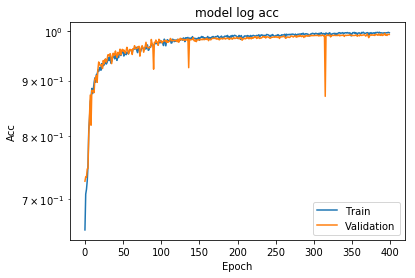

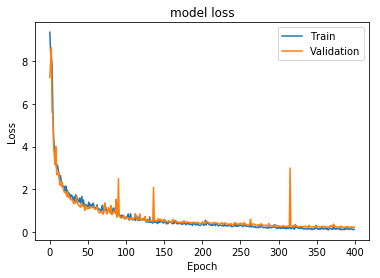

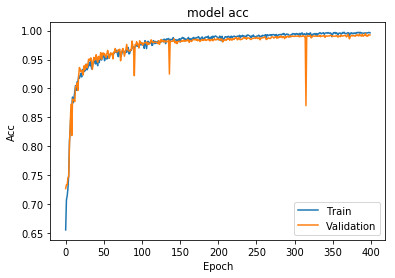

In [12]:
u.plot_loss(history, "model log loss","log")
u.plot_acc(history, "model log acc","log")

u.plot_loss(history, "model loss","linear")
u.plot_acc(history, "model acc","linear")

In [13]:
best_model= load_model('best_nbmodel_good_bad.hdf5',compile=False)

In [14]:
ypred=best_model.predict(Xtest)
ypredproba=best_model.predict_proba(Xtest)
#it's preferable to use .predict_classes because .predict might give probabilities 
#and not the label's in the case of multiclass
ypredclass=best_model.predict_classes(Xtest)

ypredclass=np.reshape(ypredclass,(ypredclass.shape[0],1))
#use argmax(1) to give the position of max value in a categorical variable like ytest
#it's basically a .predict_classes for ytest
ytestclass= ytest.argmax(1)
ytestclass=np.reshape(ytestclass,(ytestclass.shape[0],1))

Confusion matrix, without normalization
[[1211    0]
 [  15 1172]]
accuracy score:  0.993744787323


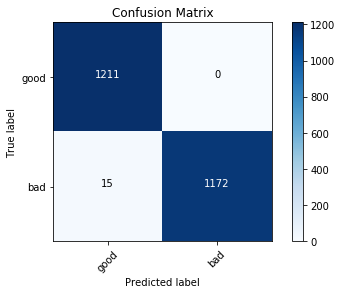

In [15]:
# from categorial to lable indexing


#yprednotcategorical =ypred.argmax(1)
#print ytestnotcategorical
#print yprednotcategorical
confusion= metrics.confusion_matrix(ytestclass,ypredclass)

plotlabels=['good','bad']
u.plot_confusion_matrix(confusion,plotlabels,title='Confusion Matrix')
print 'accuracy score: ',metrics.accuracy_score(ytestclass,ypredclass)

0.996353977893 For the label #0
0.996353977893 For the label #1


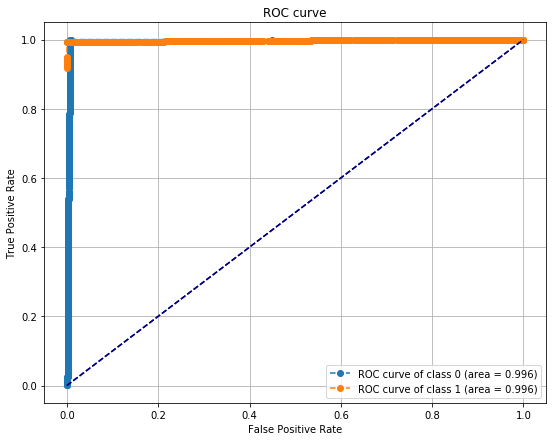

In [16]:
plt.figure(figsize=(9,7))
for i in range(ypredproba.shape[1]):
    fpr,tpr,thresholds= roc_curve(ytestclass,ypredproba[:,i],pos_label=i)
    roc_auc = auc(fpr, tpr)
    print roc_auc,'For the label #{0}'.format(i)

    plt.plot(fpr,tpr, linestyle='dashed'
             ,label='ROC curve of class {0} (area = {1:0.3f})' .format(i,roc_auc) ,marker='o')#% roc_auc, color='green'markerfacecolor='blue' ,markersize=4,
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--') 
    #plt.xlim([-.1,1.5])

    #plt.ylim([-0.1,1.5])    

    plt.title('ROC curve')

    plt.ylabel('True Positive Rate')

    plt.xlabel('False Positive Rate')

    plt.legend()

    plt.grid(True)
 

(2398, 72, 32, 1)


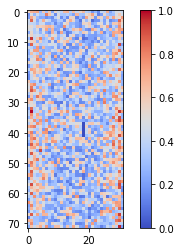

229
1.0 at: (33, 1)
0.0 at: (37, 18)
0.0 at: (38, 18)
0.0 at: (39, 18)
0.0 at: (40, 18)
0.0 at: (41, 18)


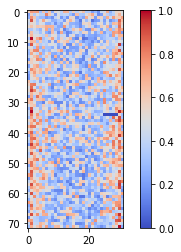

331
1.0 at: (33, 1)
0.0 at: (34, 25)
0.0 at: (34, 26)
0.0 at: (34, 27)
0.0 at: (34, 28)
0.0 at: (34, 29)


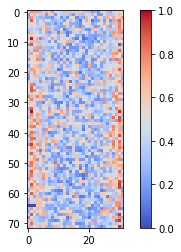

391
1.0 at: (33, 1)
0.0 at: (64, 0)
0.0 at: (64, 1)
0.0 at: (64, 2)


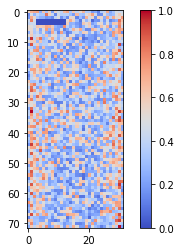

642
0.0 at: (3, 3)
0.0 at: (3, 4)
0.0 at: (3, 5)
0.0 at: (3, 6)
0.0 at: (3, 7)
0.0 at: (3, 8)
0.0 at: (3, 9)
0.0 at: (3, 10)
0.0 at: (3, 11)
0.0 at: (3, 12)
0.0 at: (4, 3)
0.0 at: (4, 4)
0.0 at: (4, 5)
0.0 at: (4, 6)
0.0 at: (4, 7)
0.0 at: (4, 8)
0.0 at: (4, 9)
0.0 at: (4, 10)
0.0 at: (4, 11)
0.0 at: (4, 12)
1.0 at: (33, 1)


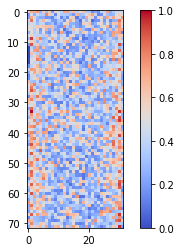

763
0.0 at: (12, 0)
0.0 at: (13, 0)
0.0 at: (14, 0)
0.0 at: (15, 0)
0.0 at: (16, 0)
0.0 at: (17, 0)
1.0 at: (33, 1)


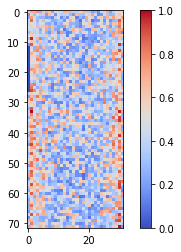

1007
0.0 at: (12, 0)
0.0 at: (13, 0)
0.0 at: (14, 0)
0.0 at: (15, 0)
0.0 at: (16, 0)
0.0 at: (17, 0)
0.0 at: (18, 0)
0.0 at: (19, 0)
0.0 at: (20, 0)
0.0 at: (21, 0)
0.0 at: (22, 0)
0.0 at: (23, 0)
0.0 at: (24, 0)
0.0 at: (25, 0)
0.0 at: (26, 0)
1.0 at: (33, 1)


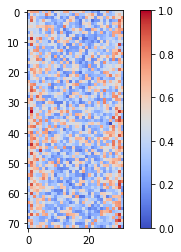

1084
1.0 at: (33, 1)
0.0 at: (37, 27)


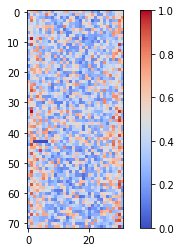

1402
1.0 at: (33, 1)
0.0 at: (43, 2)
0.0 at: (43, 3)
0.0 at: (43, 4)
0.0 at: (43, 5)
0.0 at: (43, 6)


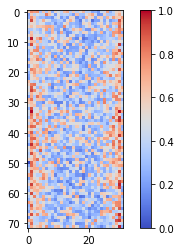

1496
1.0 at: (33, 1)
0.0 at: (50, 0)


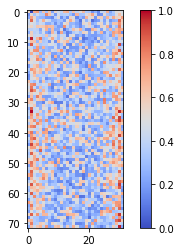

1555
0.0 at: (0, 1)
1.0 at: (33, 1)


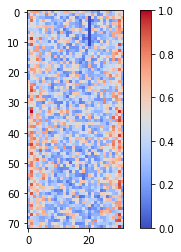

1850
0.0 at: (2, 20)
0.0 at: (3, 20)
0.0 at: (4, 20)
0.0 at: (5, 20)
0.0 at: (6, 20)
0.0 at: (7, 20)
0.0 at: (8, 20)
0.0 at: (9, 20)
0.0 at: (10, 20)
0.0 at: (11, 20)
1.0 at: (33, 1)


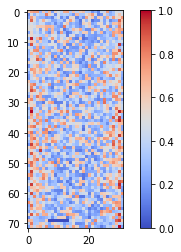

2047
1.0 at: (33, 1)
0.0 at: (69, 7)
0.0 at: (69, 8)
0.0 at: (69, 9)
0.0 at: (69, 10)
0.0 at: (69, 11)
0.0 at: (69, 12)
0.0 at: (69, 13)


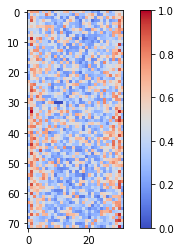

2185
0.0 at: (30, 9)
0.0 at: (30, 10)
0.0 at: (30, 11)
1.0 at: (33, 1)


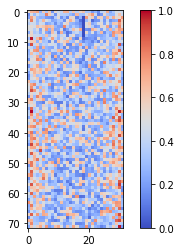

2302
0.0 at: (2, 18)
0.0 at: (3, 18)
0.0 at: (4, 18)
0.0 at: (5, 18)
0.0 at: (6, 18)
0.0 at: (7, 18)
0.0 at: (8, 18)
1.0 at: (33, 1)


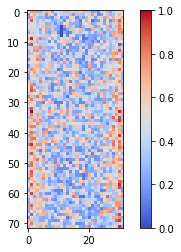

2307
0.0 at: (5, 11)
0.0 at: (6, 11)
0.0 at: (7, 11)
0.0 at: (8, 11)
1.0 at: (33, 1)


In [17]:
print Xtest.shape
for i in range(Xtest.shape[0]):
    samp = np.array([Xtest[i]])
    ypred = best_model.predict_classes(samp)
    if ypred[-1] == 0 and ytest[i][0] == 0:
        image = np.squeeze(Xtest,axis=3)[i]
        im=plt.imshow(image, cmap=cm.coolwarm)
        plt.colorbar()
        plt.show()
        plt.clf()
        print i
        for j in range(72):
            for k in range(32):
                if image[j][k] == 0.0:
                    a = (j,k)
                    print '0.0 at:', a
                if image[j][k] == 1.0:
                    b = (j,k)
                    print '1.0 at:',b

In [19]:
average_norm_occ = np.average(X)
std_norm_occ = np.std(X)

print 'mean:',average_norm_occ
print 'std:', std_norm_occ

mean: 0.336168592407
std: 0.235648849894


(2997, 72, 84)
(2997, 72, 32)
567.190321398
Shape of regular image is:  (2997, 72, 32)
Shape of dead image is:  (1546, 72, 32)
Shape of hot image is:  (1451, 72, 32)



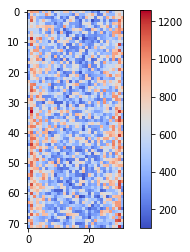

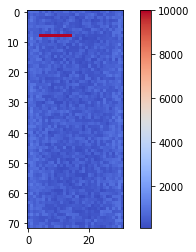

(5994, 72, 32)
X shape is:  (5994, 72, 32)
y shape is:  (5994, 2)
Xtrain.shape (3596, 72, 32)
Xtest.shape (2398, 72, 32)
ytrain.shape (3596, 2)
ytest.shape (2398, 2)
Printing labels and their corresponding images
-------------------
[ 0.  1.]


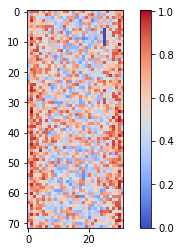

-------------------
[ 0.  1.]


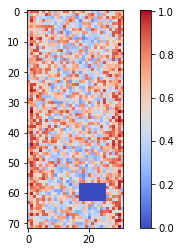

-------------------
[ 0.  1.]


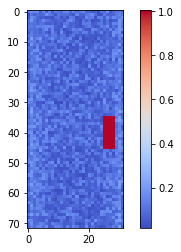

-------------------
[ 0.  1.]


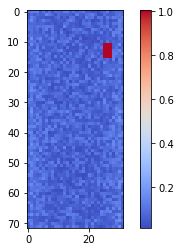

-------------------
[ 0.  1.]


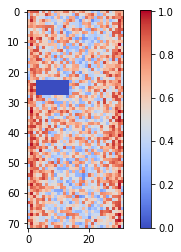

-------------------
[ 1.  0.]


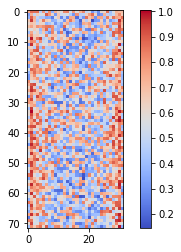

-------------------
[ 0.  1.]


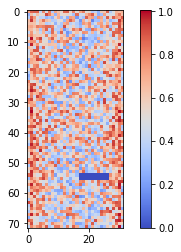

-------------------
[ 1.  0.]


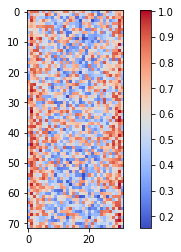

-------------------
[ 0.  1.]


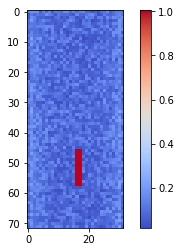

-------------------
[ 0.  1.]


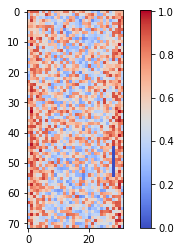

Xtrain.shape after if statement (3596, 72, 32, 1)
Xtest.shape after if statement (2398, 72, 32, 1)
ytrain.shape after if statement (3596, 2)
ytest.shape after if statement (2398, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 70, 30, 5)         50        
_________________________________________________________________
batch_normalization_4 (Batch (None, 70, 30, 5)         20        
_________________________________________________________________
activation_4 (Activation)    (None, 70, 30, 5)         0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 23, 10, 5)         0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 23, 10, 5)         0         
_________________________________________________________________
flatten_4 (Flatten)       

In [28]:
data_folder = '../../data'
file_name = 'HCAL_digi+rechit_occ.hdf5'
group = 'DigiTask_Occupancy_depth_depth1'

runs = ['306459','306138','306139']

data_sample= np.empty([0,72,84])
for run in runs:
    input_file=h5py.File(data_folder+'/'+'HCAL_digi+rechit_occ_run'+run+'.hdf5','r+')
    data_sample = np.concatenate((data_sample,np.array(input_file[group])),axis=0)
    
print data_sample.shape

data_sample=data_sample[:,:,26:58]

print data_sample.shape

average_occ = np.average(data_sample)

print average_occ

for i in range(data_sample.shape[0]):
    for j in range(data_sample.shape[1]):
        for k in range(data_sample.shape[2]):
            if data_sample[i][j][k] == 0.0:
                #print 'yo', i, j, k
                data_sample[i][j][k] = average_occ
                
input_images=data_sample[:]
hotregion_image=[]
deadregion_image=[]

for k in input_images:
    
    yn = np.random.randint(2)
    
    xLen = np.random.randint(1,17)
    yLen = np.random.randint(1,17)
    
    a=np.random.randint(input_images.shape[2]-xLen)
    b=np.random.randint(input_images.shape[1]-yLen)
    
    xdim=(a,a+xLen)
    ydim=(b,b+yLen)
    
    #print 'xdim =', xdim
    #print 'ydim =', ydim
    
    if yn == 1:
        hotregion_image.append( u.hotregion(k,xdim,ydim))
    else:
        deadregion_image.append(u.killregion(k,xdim,ydim))
       
    
hotregion_image=np.array(hotregion_image)
deadregion_image=np.array(deadregion_image)

print "Shape of regular image is: ",input_images.shape
print "Shape of dead image is: " ,deadregion_image.shape
print "Shape of hot image is: " ,hotregion_image.shape

print ''
im=plt.imshow(input_images[1],cmap=cm.coolwarm)
plt.colorbar()
plt.show()
plt.clf()

########################################################################################

im=plt.imshow(hotregion_image[1],cmap=cm.coolwarm)
plt.colorbar()
plt.show()
plt.clf()

sample= np.append(data_sample,hotregion_image,axis=0)
sample= np.append(sample,deadregion_image,axis=0)
print sample.shape

X=np.copy(sample)

y=np.zeros((sample.shape[0],1))
k=0
for img in X:
    X[k] = X[k] / np.max(img)
    k=k+1
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        for k in range(X.shape[2]):
            val = X[i][j][k]
            X[i][j][k] = val*(1.75-(0.5/0.67)*val)
#print y.shape
#print input_images.shape[0]

##########################################################################################

#this is because I am only going to add the hot and dead region images

### Changed this to a 2 class problem, good and bad
y[-1*input_images.shape[0]:]=1
#if you want it as integers leave this as it is
#if you would like it as a vector then do this

y=to_categorical(y,2)

# convert class vectors to binary class matrices
#y_train = keras.utils.to_categorical(y_train, num_classes)
#y_test = keras.utils.to_categorical(y_test, num_classes)

print "X shape is: ",X.shape
print "y shape is: ",y.shape
# input image dimensions
img_rows, img_cols = X.shape[1],X.shape[2]

Xtrain, Xtest ,ytrain, ytest =train_test_split(X,y,test_size=.4,random_state =5 )

print 'Xtrain.shape',Xtrain.shape
print 'Xtest.shape',Xtest.shape
print 'ytrain.shape',ytrain.shape
print 'ytest.shape',ytest.shape
print 'Printing labels and their corresponding images'
    
for k in range(10):
    print'-------------------'
    print ytrain[k]
    im=plt.imshow(Xtrain[k],cmap=cm.coolwarm)
    plt.colorbar()
    plt.show()
    plt.clf()


Xtrain, Xtest,input_shape= u.check_test_and_train_images_format(Xtrain, Xtest, img_rows, img_cols)

print 'Xtrain.shape after if statement',Xtrain.shape
print 'Xtest.shape after if statement',Xtest.shape
print 'ytrain.shape after if statement',ytrain.shape
print 'ytest.shape after if statement',ytest.shape

##############################################################################

"""This is a more minimal model"""

model = Sequential()

model.add(Conv2D(5, kernel_size=(3, 3), strides=(1, 1),input_shape=input_shape))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(3,3)))

model.add(Dropout(0.25))
model.add(Flatten())

#Last layer is Dense (as usual), note output size (first arg) is label size
model.add(Dense(2, activation='softmax'))


model.compile(loss=customLoss,
              optimizer='Nadam',#Adam(lr=1e-3),
              metrics=['accuracy'])

model.summary()
plot_model(model, to_file='Supervised_model.png',)

model.save('emptymodel.hdf5')

####################################################################################################

checkpointer = ModelCheckpoint(filepath='best_nbmodel_good_bad.hdf5', verbose=2, save_best_only=True)
earlystop= EarlyStopping(monitor='val_loss', min_delta=0, patience=50, verbose=1, mode='auto')

####################################################################################################

In [29]:
history = model.fit(Xtrain,ytrain,epochs=400
                    ,verbose=2
                    ,validation_data=(Xtest,ytest)
                    ,shuffle=True
                    ,callbacks=[checkpointer,earlystop])

Train on 3596 samples, validate on 2398 samples
Epoch 1/400
Epoch 00001: val_loss improved from inf to 7.51636, saving model to best_nbmodel_good_bad.hdf5
 - 25s - loss: 7.6904 - acc: 0.7319 - val_loss: 7.5164 - val_acc: 0.7398
Epoch 2/400
Epoch 00002: val_loss improved from 7.51636 to 6.92312, saving model to best_nbmodel_good_bad.hdf5
 - 24s - loss: 7.6947 - acc: 0.7389 - val_loss: 6.9231 - val_acc: 0.7423
Epoch 3/400
Epoch 00003: val_loss improved from 6.92312 to 4.06562, saving model to best_nbmodel_good_bad.hdf5
 - 24s - loss: 5.7945 - acc: 0.7784 - val_loss: 4.0656 - val_acc: 0.9616
Epoch 4/400
Epoch 00004: val_loss improved from 4.06562 to 2.47086, saving model to best_nbmodel_good_bad.hdf5
 - 24s - loss: 3.8690 - acc: 0.8537 - val_loss: 2.4709 - val_acc: 0.9395
Epoch 5/400
Epoch 00005: val_loss improved from 2.47086 to 2.14174, saving model to best_nbmodel_good_bad.hdf5
 - 22s - loss: 2.9816 - acc: 0.8832 - val_loss: 2.1417 - val_acc: 0.9053
Epoch 6/400
Epoch 00006: val_loss im

Epoch 57/400
Epoch 00057: val_loss improved from 0.53221 to 0.47835, saving model to best_nbmodel_good_bad.hdf5
 - 22s - loss: 0.3737 - acc: 0.9875 - val_loss: 0.4783 - val_acc: 0.9821
Epoch 58/400
Epoch 00058: val_loss did not improve
 - 22s - loss: 0.3501 - acc: 0.9875 - val_loss: 0.5500 - val_acc: 0.9800
Epoch 59/400
Epoch 00059: val_loss did not improve
 - 23s - loss: 0.5502 - acc: 0.9805 - val_loss: 0.6480 - val_acc: 0.9758
Epoch 60/400
Epoch 00060: val_loss did not improve
 - 22s - loss: 0.4960 - acc: 0.9833 - val_loss: 0.6529 - val_acc: 0.9746
Epoch 61/400
Epoch 00061: val_loss did not improve
 - 22s - loss: 0.3626 - acc: 0.9869 - val_loss: 0.6901 - val_acc: 0.9729
Epoch 62/400
Epoch 00062: val_loss did not improve
 - 22s - loss: 0.3245 - acc: 0.9894 - val_loss: 0.5523 - val_acc: 0.9796
Epoch 63/400
Epoch 00063: val_loss did not improve
 - 22s - loss: 0.4355 - acc: 0.9836 - val_loss: 0.6540 - val_acc: 0.9771
Epoch 64/400
Epoch 00064: val_loss did not improve
 - 22s - loss: 0.380

Epoch 119/400
Epoch 00119: val_loss did not improve
 - 24s - loss: 0.2421 - acc: 0.9914 - val_loss: 0.4730 - val_acc: 0.9825
Epoch 120/400
Epoch 00120: val_loss did not improve
 - 23s - loss: 0.2231 - acc: 0.9928 - val_loss: 0.4556 - val_acc: 0.9821
Epoch 121/400
Epoch 00121: val_loss did not improve
 - 23s - loss: 0.1629 - acc: 0.9950 - val_loss: 0.5237 - val_acc: 0.9804
Epoch 122/400
Epoch 00122: val_loss improved from 0.40268 to 0.38168, saving model to best_nbmodel_good_bad.hdf5
 - 23s - loss: 0.1837 - acc: 0.9936 - val_loss: 0.3817 - val_acc: 0.9862
Epoch 123/400
Epoch 00123: val_loss did not improve
 - 23s - loss: 0.2260 - acc: 0.9905 - val_loss: 0.4044 - val_acc: 0.9842
Epoch 124/400
Epoch 00124: val_loss did not improve
 - 25s - loss: 0.2026 - acc: 0.9933 - val_loss: 0.4262 - val_acc: 0.9837
Epoch 125/400
Epoch 00125: val_loss did not improve
 - 24s - loss: 0.1675 - acc: 0.9942 - val_loss: 0.4087 - val_acc: 0.9842
Epoch 126/400
Epoch 00126: val_loss improved from 0.38168 to 0.3

Epoch 182/400
Epoch 00182: val_loss did not improve
 - 25s - loss: 0.1046 - acc: 0.9961 - val_loss: 0.2803 - val_acc: 0.9892
Epoch 183/400
Epoch 00183: val_loss improved from 0.26991 to 0.26922, saving model to best_nbmodel_good_bad.hdf5
 - 23s - loss: 0.1010 - acc: 0.9969 - val_loss: 0.2692 - val_acc: 0.9896
Epoch 184/400
Epoch 00184: val_loss did not improve
 - 23s - loss: 0.1114 - acc: 0.9961 - val_loss: 0.3611 - val_acc: 0.9858
Epoch 185/400
Epoch 00185: val_loss did not improve
 - 22s - loss: 0.0762 - acc: 0.9978 - val_loss: 0.3277 - val_acc: 0.9871
Epoch 186/400
Epoch 00186: val_loss did not improve
 - 22s - loss: 0.0920 - acc: 0.9969 - val_loss: 0.3127 - val_acc: 0.9879
Epoch 187/400
Epoch 00187: val_loss improved from 0.26922 to 0.25522, saving model to best_nbmodel_good_bad.hdf5
 - 22s - loss: 0.0796 - acc: 0.9978 - val_loss: 0.2552 - val_acc: 0.9904
Epoch 188/400
Epoch 00188: val_loss did not improve
 - 22s - loss: 0.0789 - acc: 0.9969 - val_loss: 0.3008 - val_acc: 0.9879
Epo

Epoch 243/400
Epoch 00243: val_loss did not improve
 - 25s - loss: 0.0567 - acc: 0.9983 - val_loss: 0.2114 - val_acc: 0.9912
Epoch 244/400
Epoch 00244: val_loss did not improve
 - 24s - loss: 0.0469 - acc: 0.9986 - val_loss: 0.1854 - val_acc: 0.9933
Epoch 245/400
Epoch 00245: val_loss did not improve
 - 23s - loss: 0.0524 - acc: 0.9986 - val_loss: 0.1984 - val_acc: 0.9933
Epoch 246/400
Epoch 00246: val_loss did not improve
 - 23s - loss: 0.0404 - acc: 0.9986 - val_loss: 0.2281 - val_acc: 0.9917
Epoch 247/400
Epoch 00247: val_loss did not improve
 - 22s - loss: 0.0370 - acc: 0.9986 - val_loss: 0.2158 - val_acc: 0.9921
Epoch 248/400
Epoch 00248: val_loss did not improve
 - 22s - loss: 0.0293 - acc: 0.9992 - val_loss: 0.2198 - val_acc: 0.9921
Epoch 249/400
Epoch 00249: val_loss did not improve
 - 23s - loss: 0.0407 - acc: 0.9983 - val_loss: 0.1973 - val_acc: 0.9933
Epoch 250/400
Epoch 00250: val_loss did not improve
 - 23s - loss: 0.0659 - acc: 0.9975 - val_loss: 0.2163 - val_acc: 0.9917


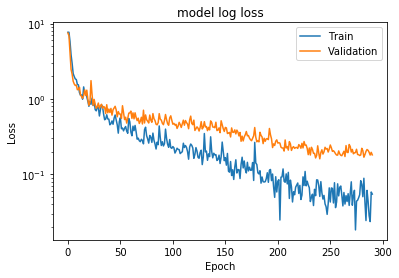

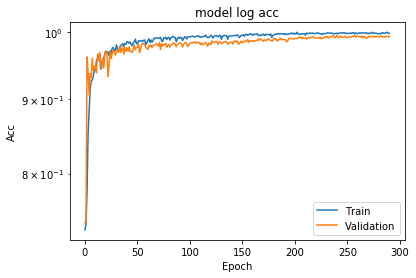

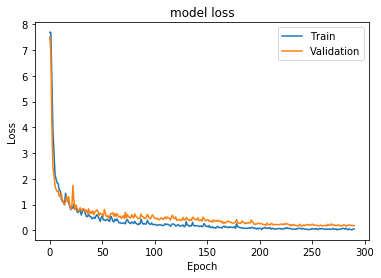

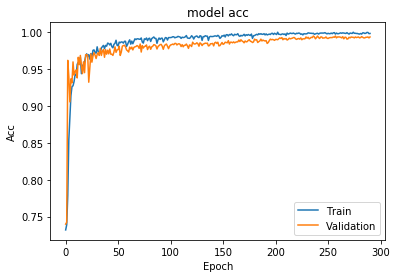

In [30]:
u.plot_loss(history, "model log loss", "log")
u.plot_acc(history, "model log acc", "log")

u.plot_loss(history, "model loss", "linear")
u.plot_acc(history, "model acc", "linear")

Confusion matrix, without normalization
[[1211    0]
 [  13 1174]]
accuracy score:  0.99457881568
0.998565174471 For the label #0
0.998565174471 For the label #1
(2398, 72, 32, 1)


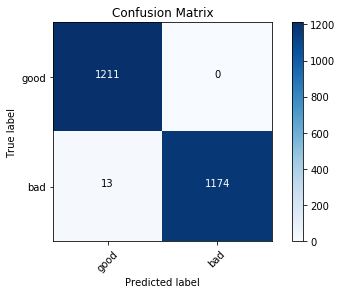

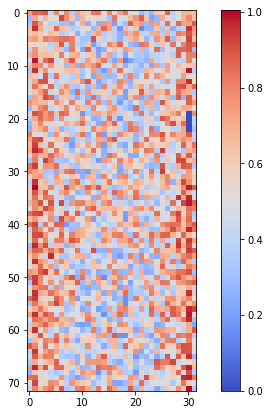

507
0.0 at: (19, 30)
0.0 at: (20, 30)
0.0 at: (21, 30)
0.0 at: (22, 30)


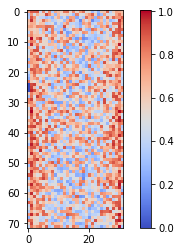

548
0.0 at: (24, 0)
0.0 at: (25, 0)
0.0 at: (26, 0)


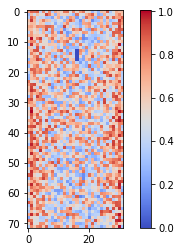

628
0.0 at: (13, 16)
0.0 at: (14, 16)
0.0 at: (15, 16)
0.0 at: (16, 16)


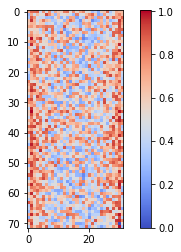

900
0.0 at: (70, 30)


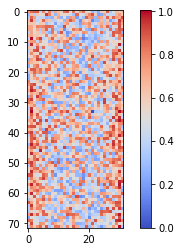

1207
0.0 at: (33, 21)


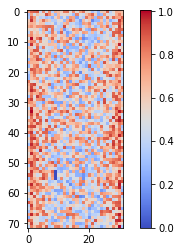

1374
0.0 at: (53, 9)
0.0 at: (54, 9)
0.0 at: (55, 9)


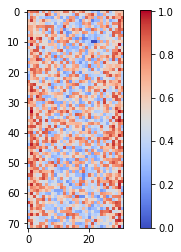

1454
0.0 at: (10, 21)
0.0 at: (10, 22)


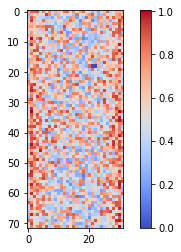

1692
0.0 at: (18, 21)
0.0 at: (18, 22)


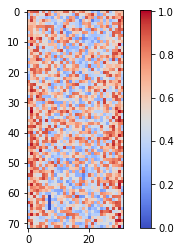

1852
0.0 at: (61, 7)
0.0 at: (62, 7)
0.0 at: (63, 7)
0.0 at: (64, 7)
0.0 at: (65, 7)


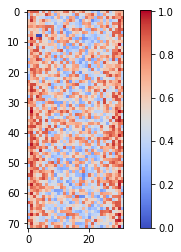

1914
0.0 at: (8, 3)
0.0 at: (8, 4)


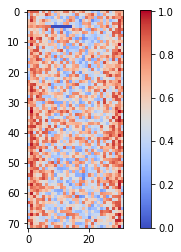

1921
0.0 at: (5, 8)
0.0 at: (5, 9)
0.0 at: (5, 10)
0.0 at: (5, 11)
0.0 at: (5, 12)
0.0 at: (5, 13)
0.0 at: (5, 14)


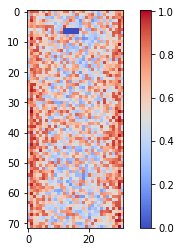

2030
0.0 at: (6, 12)
0.0 at: (6, 13)
0.0 at: (6, 14)
0.0 at: (6, 15)
0.0 at: (6, 16)
0.0 at: (7, 12)
0.0 at: (7, 13)
0.0 at: (7, 14)
0.0 at: (7, 15)
0.0 at: (7, 16)


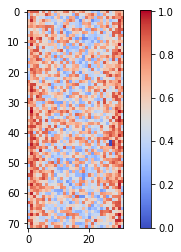

2357
0.0 at: (43, 27)
0.0 at: (44, 27)


In [31]:
best_model= load_model('best_nbmodel_good_bad.hdf5',compile=False)

##################################################################

ypred=best_model.predict(Xtest)
ypredproba=best_model.predict_proba(Xtest)
#it's preferable to use .predict_classes because .predict might give probabilities 
#and not the label's in the case of multiclass
ypredclass=best_model.predict_classes(Xtest)

ypredclass=np.reshape(ypredclass,(ypredclass.shape[0],1))
#use argmax(1) to give the position of max value in a categorical variable like ytest
#it's basically a .predict_classes for ytest
ytestclass= ytest.argmax(1)
ytestclass=np.reshape(ytestclass,(ytestclass.shape[0],1))

# from categorial to lable indexing

#yprednotcategorical =ypred.argmax(1)
#print ytestnotcategorical
#print yprednotcategorical
confusion= metrics.confusion_matrix(ytestclass,ypredclass)

plotlabels=['good','bad']
u.plot_confusion_matrix(confusion,plotlabels,title='Confusion Matrix')
print 'accuracy score: ',metrics.accuracy_score(ytestclass,ypredclass)

###################################################################################

plt.figure(figsize=(9,7))
for i in range(ypredproba.shape[1]):
    fpr,tpr,thresholds= roc_curve(ytestclass,ypredproba[:,i],pos_label=i)
    roc_auc = auc(fpr, tpr)
    print roc_auc,'For the label #{0}'.format(i)

    plt.plot(fpr,tpr, linestyle='dashed'
             ,label='ROC curve of class {0} (area = {1:0.3f})' .format(i,roc_auc) ,marker='o')#% roc_auc, color='green'markerfacecolor='blue' ,markersize=4,
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--') 
    #plt.xlim([-.1,1.5])

    #plt.ylim([-0.1,1.5])    

    plt.title('ROC curve')

    plt.ylabel('True Positive Rate')

    plt.xlabel('False Positive Rate')

    plt.legend()

    plt.grid(True)
plt.clf()
    
##############################################################################

print Xtest.shape
for i in range(Xtest.shape[0]):
    samp = np.array([Xtest[i]])
    ypred = best_model.predict_classes(samp)
    if ypred[-1] == 0 and ytest[i][0] == 0:
        image = np.squeeze(Xtest,axis=3)[i]
        im=plt.imshow(image, cmap=cm.coolwarm)
        plt.colorbar()
        plt.show()
        plt.clf()
        print i
        for j in range(72):
            for k in range(32):
                if image[j][k] == 0.0:
                    a = (j,k)
                    print '0.0 at:', a
                if image[j][k] == 1.0:
                    b = (j,k)
                    print '1.0 at:',b

In [32]:
average_norm_occ = np.average(X)
std_norm_occ = np.std(X)

print 'mean:',average_norm_occ
print 'std:', std_norm_occ

mean: 0.464925771899
std: 0.277461348828


(2997, 72, 84)
(2997, 72, 32)
567.190321398
Shape of regular image is:  (2997, 72, 32)
Shape of dead image is:  (2233, 72, 32)
Shape of hot image is:  (764, 72, 32)



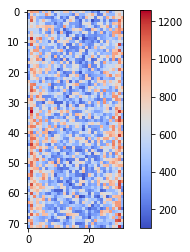

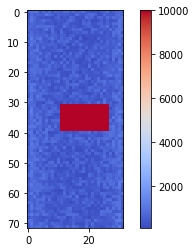

(5994, 72, 32)
X shape is:  (5994, 74, 34)
y shape is:  (5994, 2)
Xtrain.shape (3596, 74, 34)
Xtest.shape (2398, 74, 34)
ytrain.shape (3596, 2)
ytest.shape (2398, 2)
Printing labels and their corresponding images
-------------------
[ 0.  1.]


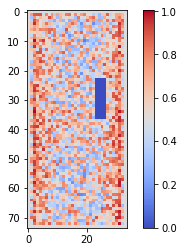

-------------------
[ 0.  1.]


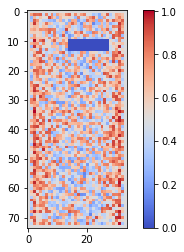

-------------------
[ 0.  1.]


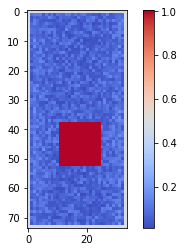

-------------------
[ 0.  1.]


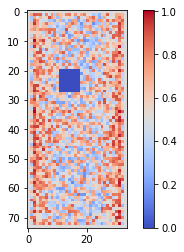

-------------------
[ 0.  1.]


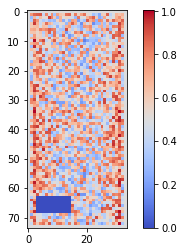

-------------------
[ 1.  0.]


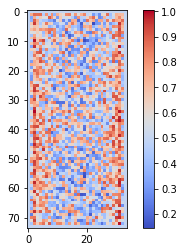

-------------------
[ 0.  1.]


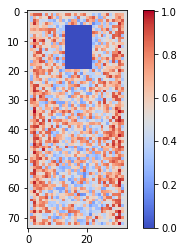

-------------------
[ 1.  0.]


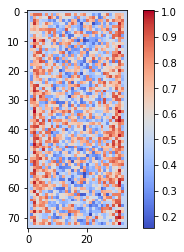

-------------------
[ 0.  1.]


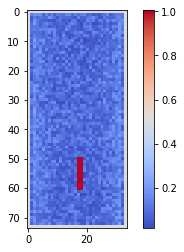

-------------------
[ 0.  1.]


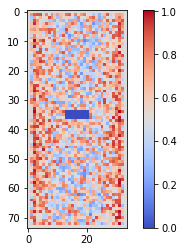

Xtrain.shape after if statement (3596, 74, 34, 1)
Xtest.shape after if statement (2398, 74, 34, 1)
ytrain.shape after if statement (3596, 2)
ytest.shape after if statement (2398, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 72, 32, 5)         50        
_________________________________________________________________
batch_normalization_11 (Batc (None, 72, 32, 5)         20        
_________________________________________________________________
activation_11 (Activation)   (None, 72, 32, 5)         0         
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 24, 10, 5)         0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 24, 10, 5)         0         
_________________________________________________________________
flatten_11 (Flatten)      

In [50]:
data_folder = '../../data'
file_name = 'HCAL_digi+rechit_occ.hdf5'
group = 'DigiTask_Occupancy_depth_depth1'

runs = ['306459','306138','306139']

data_sample= np.empty([0,72,84])
for run in runs:
    input_file=h5py.File(data_folder+'/'+'HCAL_digi+rechit_occ_run'+run+'.hdf5','r+')
    data_sample = np.concatenate((data_sample,np.array(input_file[group])),axis=0)
    
print data_sample.shape

data_sample=data_sample[:,:,26:58]

print data_sample.shape

average_occ = np.average(data_sample)

print average_occ

for i in range(data_sample.shape[0]):
    for j in range(data_sample.shape[1]):
        for k in range(data_sample.shape[2]):
            if data_sample[i][j][k] == 0.0:
                #print 'yo', i, j, k
                data_sample[i][j][k] = average_occ
                
input_images=data_sample[:]
hotregion_image=[]
deadregion_image=[]

for k in input_images:
    
    yn = np.random.randint(4)
    
    xLen = np.random.randint(1,17)
    yLen = np.random.randint(1,17)
    
    a=np.random.randint(input_images.shape[2]-xLen)
    b=np.random.randint(input_images.shape[1]-yLen)
    
    xdim=(a,a+xLen)
    ydim=(b,b+yLen)
    
    #print 'xdim =', xdim
    #print 'ydim =', ydim
    
    if yn == 1:
        hotregion_image.append( u.hotregion(k,xdim,ydim))
    else:
        deadregion_image.append(u.killregion(k,xdim,ydim))
       
    
hotregion_image=np.array(hotregion_image)
deadregion_image=np.array(deadregion_image)

print "Shape of regular image is: ",input_images.shape
print "Shape of dead image is: " ,deadregion_image.shape
print "Shape of hot image is: " ,hotregion_image.shape

print ''
im=plt.imshow(input_images[1],cmap=cm.coolwarm)
plt.colorbar()
plt.show()
plt.clf()

########################################################################################

im=plt.imshow(hotregion_image[1],cmap=cm.coolwarm)
plt.colorbar()
plt.show()
plt.clf()

sample= np.append(data_sample,hotregion_image,axis=0)
sample= np.append(sample,deadregion_image,axis=0)
print sample.shape

X=np.copy(sample)

y=np.zeros((sample.shape[0],1))
k=0
for img in X:
    X[k] = X[k] / np.max(img)
    k=k+1
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        for k in range(X.shape[2]):
            val = X[i][j][k]
            X[i][j][k] = val*(1.75-(0.5/0.67)*val)
"""Add the padding layer of 0.5s"""
X_shape = X.shape
filler = np.ones((X_shape[0],X_shape[1]+2,X_shape[2]+2))/2
for i in range(X_shape[0]):
    for j in range(1,X_shape[1]+1):
        for k in range(1,X_shape[2]+1):
            filler[i][j][k] = X[i][j-1][k-1]
            
X = filler

##########################################################################################

#this is because I am only going to add the hot and dead region images

### Changed this to a 2 class problem, good and bad
y[-1*input_images.shape[0]:]=1
#if you want it as integers leave this as it is
#if you would like it as a vector then do this

y=to_categorical(y,2)

# convert class vectors to binary class matrices
#y_train = keras.utils.to_categorical(y_train, num_classes)
#y_test = keras.utils.to_categorical(y_test, num_classes)

print "X shape is: ",X.shape
print "y shape is: ",y.shape
# input image dimensions
img_rows, img_cols = X.shape[1],X.shape[2]

Xtrain, Xtest ,ytrain, ytest =train_test_split(X,y,test_size=.4,random_state =5 )

print 'Xtrain.shape',Xtrain.shape
print 'Xtest.shape',Xtest.shape
print 'ytrain.shape',ytrain.shape
print 'ytest.shape',ytest.shape
print 'Printing labels and their corresponding images'
    
for k in range(10):
    print'-------------------'
    print ytrain[k]
    im=plt.imshow(Xtrain[k],cmap=cm.coolwarm)
    plt.colorbar()
    plt.show()
    plt.clf()


Xtrain, Xtest,input_shape= u.check_test_and_train_images_format(Xtrain, Xtest, img_rows, img_cols)

print 'Xtrain.shape after if statement',Xtrain.shape
print 'Xtest.shape after if statement',Xtest.shape
print 'ytrain.shape after if statement',ytrain.shape
print 'ytest.shape after if statement',ytest.shape

##############################################################################

"""This is a more minimal model"""

model = Sequential()

model.add(Conv2D(5, kernel_size=(3, 3), strides=(1, 1),input_shape=input_shape))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(3,3)))

model.add(Dropout(0.25))
model.add(Flatten())

#Last layer is Dense (as usual), note output size (first arg) is label size
model.add(Dense(2, activation='softmax'))


model.compile(loss=customLoss,
              optimizer='Nadam',#Adam(lr=1e-3),
              metrics=['accuracy'])

model.summary()
plot_model(model, to_file='Supervised_model.png',)

model.save('emptymodel.hdf5')

####################################################################################################

checkpointer = ModelCheckpoint(filepath='best_nbmodel_good_bad.hdf5', verbose=2, save_best_only=True)
earlystop= EarlyStopping(monitor='val_loss', min_delta=0, patience=50, verbose=1, mode='auto')

####################################################################################################

In [51]:
history = model.fit(Xtrain,ytrain,epochs=400
                    ,verbose=2
                    ,validation_data=(Xtest,ytest)
                    ,shuffle=True
                    ,callbacks=[checkpointer,earlystop])

Train on 3596 samples, validate on 2398 samples
Epoch 1/400
Epoch 00001: val_loss improved from inf to 6.29031, saving model to best_nbmodel_good_bad.hdf5
 - 26s - loss: 9.7101 - acc: 0.6085 - val_loss: 6.2903 - val_acc: 0.6489
Epoch 2/400
Epoch 00002: val_loss did not improve
 - 24s - loss: 6.9248 - acc: 0.6977 - val_loss: 7.3044 - val_acc: 0.6614
Epoch 3/400
Epoch 00003: val_loss improved from 6.29031 to 4.05506, saving model to best_nbmodel_good_bad.hdf5
 - 24s - loss: 5.5021 - acc: 0.7494 - val_loss: 4.0551 - val_acc: 0.8128
Epoch 4/400
Epoch 00004: val_loss improved from 4.05506 to 4.02657, saving model to best_nbmodel_good_bad.hdf5
 - 24s - loss: 4.3417 - acc: 0.8084 - val_loss: 4.0266 - val_acc: 0.8107
Epoch 5/400
Epoch 00005: val_loss improved from 4.02657 to 3.46191, saving model to best_nbmodel_good_bad.hdf5
 - 24s - loss: 3.8644 - acc: 0.8482 - val_loss: 3.4619 - val_acc: 0.8403
Epoch 6/400
Epoch 00006: val_loss did not improve
 - 24s - loss: 3.6174 - acc: 0.8476 - val_loss:

Epoch 57/400
Epoch 00057: val_loss improved from 0.86567 to 0.82520, saving model to best_nbmodel_good_bad.hdf5
 - 24s - loss: 0.8862 - acc: 0.9711 - val_loss: 0.8252 - val_acc: 0.9696
Epoch 58/400
Epoch 00058: val_loss did not improve
 - 24s - loss: 0.9065 - acc: 0.9669 - val_loss: 0.8307 - val_acc: 0.9721
Epoch 59/400
Epoch 00059: val_loss improved from 0.82520 to 0.79535, saving model to best_nbmodel_good_bad.hdf5
 - 24s - loss: 0.9004 - acc: 0.9675 - val_loss: 0.7953 - val_acc: 0.9712
Epoch 60/400
Epoch 00060: val_loss did not improve
 - 24s - loss: 0.8183 - acc: 0.9719 - val_loss: 0.8179 - val_acc: 0.9741
Epoch 61/400
Epoch 00061: val_loss did not improve
 - 25s - loss: 0.9123 - acc: 0.9664 - val_loss: 12.5669 - val_acc: 0.4946
Epoch 62/400
Epoch 00062: val_loss did not improve
 - 24s - loss: 0.9288 - acc: 0.9672 - val_loss: 16.0677 - val_acc: 0.4950
Epoch 63/400
Epoch 00063: val_loss did not improve
 - 24s - loss: 0.8256 - acc: 0.9733 - val_loss: 1.5511 - val_acc: 0.9791
Epoch 64

Epoch 116/400
Epoch 00116: val_loss did not improve
 - 24s - loss: 0.4932 - acc: 0.9833 - val_loss: 0.5281 - val_acc: 0.9817
Epoch 117/400
Epoch 00117: val_loss did not improve
 - 23s - loss: 0.5435 - acc: 0.9816 - val_loss: 0.5538 - val_acc: 0.9779
Epoch 118/400
Epoch 00118: val_loss did not improve
 - 24s - loss: 0.4540 - acc: 0.9844 - val_loss: 0.5421 - val_acc: 0.9775
Epoch 119/400
Epoch 00119: val_loss did not improve
 - 24s - loss: 0.4728 - acc: 0.9833 - val_loss: 0.5015 - val_acc: 0.9808
Epoch 120/400
Epoch 00120: val_loss improved from 0.48125 to 0.47863, saving model to best_nbmodel_good_bad.hdf5
 - 24s - loss: 0.5203 - acc: 0.9814 - val_loss: 0.4786 - val_acc: 0.9850
Epoch 121/400
Epoch 00121: val_loss did not improve
 - 24s - loss: 0.4923 - acc: 0.9819 - val_loss: 0.4924 - val_acc: 0.9837
Epoch 122/400
Epoch 00122: val_loss did not improve
 - 23s - loss: 0.5467 - acc: 0.9814 - val_loss: 0.4822 - val_acc: 0.9842
Epoch 123/400
Epoch 00123: val_loss did not improve
 - 24s - los

Epoch 178/400
Epoch 00178: val_loss improved from 0.38457 to 0.36897, saving model to best_nbmodel_good_bad.hdf5
 - 24s - loss: 0.3202 - acc: 0.9900 - val_loss: 0.3690 - val_acc: 0.9875
Epoch 179/400
Epoch 00179: val_loss did not improve
 - 24s - loss: 0.3315 - acc: 0.9875 - val_loss: 0.4104 - val_acc: 0.9837
Epoch 180/400
Epoch 00180: val_loss did not improve
 - 24s - loss: 0.3510 - acc: 0.9875 - val_loss: 0.4732 - val_acc: 0.9908
Epoch 181/400
Epoch 00181: val_loss did not improve
 - 24s - loss: 0.2900 - acc: 0.9905 - val_loss: 0.3740 - val_acc: 0.9862
Epoch 182/400
Epoch 00182: val_loss did not improve
 - 24s - loss: 0.3829 - acc: 0.9878 - val_loss: 0.3932 - val_acc: 0.9858
Epoch 183/400
Epoch 00183: val_loss did not improve
 - 24s - loss: 0.3387 - acc: 0.9897 - val_loss: 0.4439 - val_acc: 0.9829
Epoch 184/400
Epoch 00184: val_loss did not improve
 - 24s - loss: 0.3074 - acc: 0.9900 - val_loss: 0.3710 - val_acc: 0.9879
Epoch 185/400
Epoch 00185: val_loss did not improve
 - 24s - los

Epoch 239/400
Epoch 00239: val_loss did not improve
 - 24s - loss: 0.2081 - acc: 0.9930 - val_loss: 0.2873 - val_acc: 0.9883
Epoch 240/400
Epoch 00240: val_loss improved from 0.28672 to 0.28572, saving model to best_nbmodel_good_bad.hdf5
 - 25s - loss: 0.2462 - acc: 0.9919 - val_loss: 0.2857 - val_acc: 0.9887
Epoch 241/400
Epoch 00241: val_loss did not improve
 - 24s - loss: 0.2795 - acc: 0.9903 - val_loss: 0.5698 - val_acc: 0.9875
Epoch 242/400
Epoch 00242: val_loss did not improve
 - 25s - loss: 0.2885 - acc: 0.9900 - val_loss: 0.3194 - val_acc: 0.9879
Epoch 243/400
Epoch 00243: val_loss did not improve
 - 24s - loss: 0.2084 - acc: 0.9930 - val_loss: 0.2935 - val_acc: 0.9883
Epoch 244/400
Epoch 00244: val_loss improved from 0.28572 to 0.27717, saving model to best_nbmodel_good_bad.hdf5
 - 24s - loss: 0.2708 - acc: 0.9905 - val_loss: 0.2772 - val_acc: 0.9900
Epoch 245/400
Epoch 00245: val_loss did not improve
 - 24s - loss: 0.3020 - acc: 0.9889 - val_loss: 0.4353 - val_acc: 0.9921
Epo

 - 24s - loss: 0.2034 - acc: 0.9922 - val_loss: 0.2309 - val_acc: 0.9921
Epoch 302/400
Epoch 00302: val_loss did not improve
 - 24s - loss: 0.1341 - acc: 0.9958 - val_loss: 0.2316 - val_acc: 0.9917
Epoch 303/400
Epoch 00303: val_loss did not improve
 - 24s - loss: 0.1595 - acc: 0.9947 - val_loss: 0.2410 - val_acc: 0.9908
Epoch 304/400
Epoch 00304: val_loss did not improve
 - 24s - loss: 0.1666 - acc: 0.9942 - val_loss: 0.2446 - val_acc: 0.9900
Epoch 305/400
Epoch 00305: val_loss did not improve
 - 24s - loss: 0.1580 - acc: 0.9944 - val_loss: 0.2793 - val_acc: 0.9896
Epoch 306/400
Epoch 00306: val_loss did not improve
 - 24s - loss: 0.2258 - acc: 0.9922 - val_loss: 0.7406 - val_acc: 0.9917
Epoch 307/400
Epoch 00307: val_loss did not improve
 - 24s - loss: 0.1560 - acc: 0.9950 - val_loss: 0.2489 - val_acc: 0.9900
Epoch 308/400
Epoch 00308: val_loss did not improve
 - 24s - loss: 0.1299 - acc: 0.9958 - val_loss: 0.2430 - val_acc: 0.9904
Epoch 309/400
Epoch 00309: val_loss did not improve


Epoch 363/400
Epoch 00363: val_loss did not improve
 - 24s - loss: 0.0826 - acc: 0.9978 - val_loss: 0.1653 - val_acc: 0.9921
Epoch 364/400
Epoch 00364: val_loss improved from 0.16364 to 0.14653, saving model to best_nbmodel_good_bad.hdf5
 - 24s - loss: 0.0897 - acc: 0.9972 - val_loss: 0.1465 - val_acc: 0.9954
Epoch 365/400
Epoch 00365: val_loss did not improve
 - 24s - loss: 0.0611 - acc: 0.9983 - val_loss: 0.1793 - val_acc: 0.9925
Epoch 366/400
Epoch 00366: val_loss did not improve
 - 24s - loss: 0.0567 - acc: 0.9981 - val_loss: 0.1810 - val_acc: 0.9929
Epoch 367/400
Epoch 00367: val_loss did not improve
 - 24s - loss: 0.1184 - acc: 0.9956 - val_loss: 0.1512 - val_acc: 0.9937
Epoch 368/400
Epoch 00368: val_loss did not improve
 - 24s - loss: 0.0726 - acc: 0.9975 - val_loss: 0.1575 - val_acc: 0.9933
Epoch 369/400
Epoch 00369: val_loss did not improve
 - 24s - loss: 0.0768 - acc: 0.9975 - val_loss: 0.1999 - val_acc: 0.9921
Epoch 370/400
Epoch 00370: val_loss did not improve
 - 24s - los

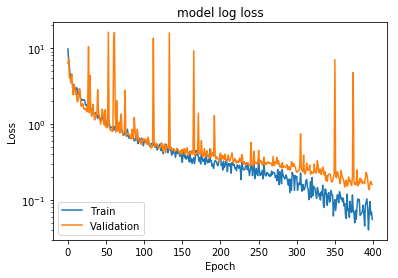

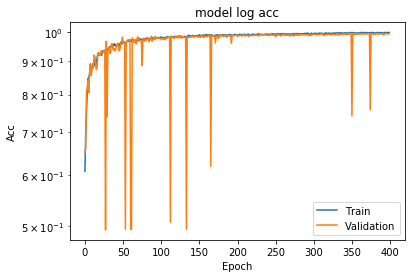

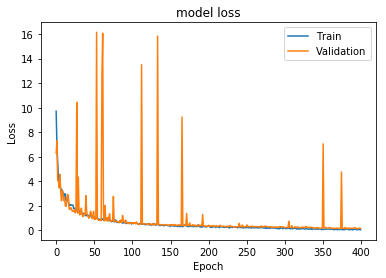

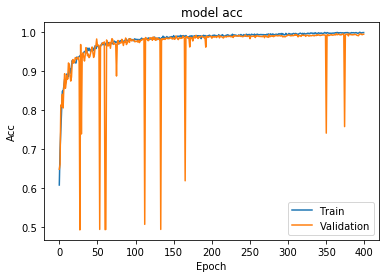

In [52]:
u.plot_loss(history, "model log loss", "log")
u.plot_acc(history, "model log acc", "log")

u.plot_loss(history, "model loss", "linear")
u.plot_acc(history, "model acc", "linear")

Confusion matrix, without normalization
[[1211    0]
 [  13 1174]]
accuracy score:  0.99457881568
0.998152988229 For the label #0
0.998152988229 For the label #1
(2398, 74, 34, 1)


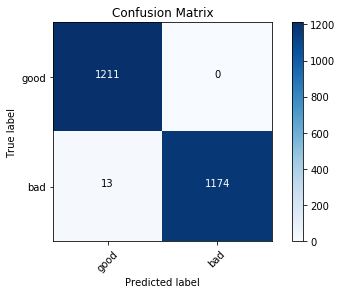

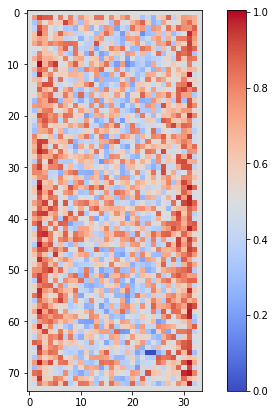

187
0.0 at: (66, 23)
0.0 at: (66, 24)


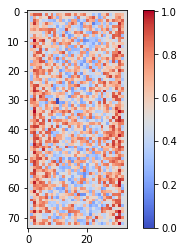

212
0.0 at: (30, 10)
0.0 at: (31, 10)


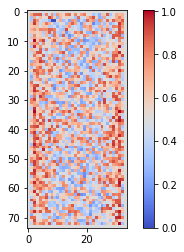

332
0.0 at: (3, 8)
0.0 at: (3, 9)


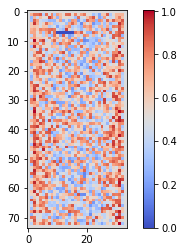

704
0.0 at: (7, 10)
0.0 at: (7, 11)
0.0 at: (7, 12)
0.0 at: (7, 13)
0.0 at: (7, 14)
0.0 at: (7, 15)


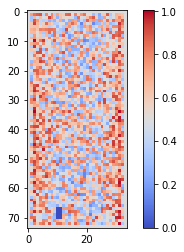

933
0.0 at: (67, 10)
0.0 at: (67, 11)
0.0 at: (68, 10)
0.0 at: (68, 11)
0.0 at: (69, 10)
0.0 at: (69, 11)
0.0 at: (70, 10)
0.0 at: (70, 11)


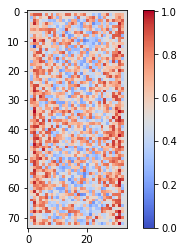

1057
0.0 at: (12, 2)


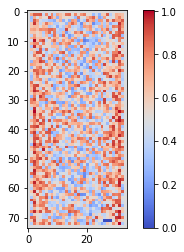

1060
0.0 at: (71, 26)
0.0 at: (71, 27)
0.0 at: (71, 28)


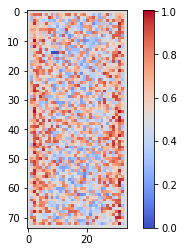

1071
0.0 at: (14, 8)
0.0 at: (14, 9)
0.0 at: (14, 10)


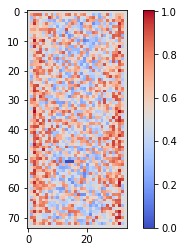

1160
0.0 at: (51, 13)
0.0 at: (51, 14)
0.0 at: (51, 15)


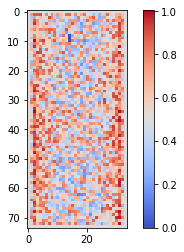

1548
0.0 at: (8, 14)
0.0 at: (9, 14)
0.0 at: (10, 14)


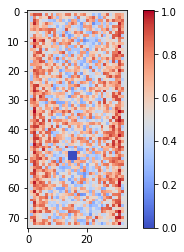

1768
0.0 at: (48, 14)
0.0 at: (48, 15)
0.0 at: (48, 16)
0.0 at: (49, 14)
0.0 at: (49, 15)
0.0 at: (49, 16)
0.0 at: (50, 14)
0.0 at: (50, 15)
0.0 at: (50, 16)


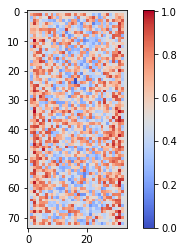

2226
0.0 at: (23, 16)
0.0 at: (24, 16)


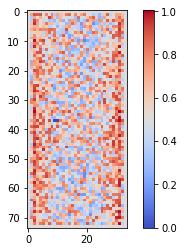

2360
0.0 at: (37, 9)
0.0 at: (37, 10)


In [53]:
best_model= load_model('best_nbmodel_good_bad.hdf5',compile=False)

##################################################################

ypred=best_model.predict(Xtest)
ypredproba=best_model.predict_proba(Xtest)
#it's preferable to use .predict_classes because .predict might give probabilities 
#and not the label's in the case of multiclass
ypredclass=best_model.predict_classes(Xtest)

ypredclass=np.reshape(ypredclass,(ypredclass.shape[0],1))
#use argmax(1) to give the position of max value in a categorical variable like ytest
#it's basically a .predict_classes for ytest
ytestclass= ytest.argmax(1)
ytestclass=np.reshape(ytestclass,(ytestclass.shape[0],1))

# from categorial to lable indexing

#yprednotcategorical =ypred.argmax(1)
#print ytestnotcategorical
#print yprednotcategorical
confusion= metrics.confusion_matrix(ytestclass,ypredclass)

plotlabels=['good','bad']
u.plot_confusion_matrix(confusion,plotlabels,title='Confusion Matrix')
print 'accuracy score: ',metrics.accuracy_score(ytestclass,ypredclass)

###################################################################################

plt.figure(figsize=(9,7))
for i in range(ypredproba.shape[1]):
    fpr,tpr,thresholds= roc_curve(ytestclass,ypredproba[:,i],pos_label=i)
    roc_auc = auc(fpr, tpr)
    print roc_auc,'For the label #{0}'.format(i)

    plt.plot(fpr,tpr, linestyle='dashed'
             ,label='ROC curve of class {0} (area = {1:0.3f})' .format(i,roc_auc) ,marker='o')#% roc_auc, color='green'markerfacecolor='blue' ,markersize=4,
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--') 
    #plt.xlim([-.1,1.5])

    #plt.ylim([-0.1,1.5])    

    plt.title('ROC curve')

    plt.ylabel('True Positive Rate')

    plt.xlabel('False Positive Rate')

    plt.legend()

    plt.grid(True)
plt.clf()
    
##############################################################################

print Xtest.shape
for i in range(Xtest.shape[0]):
    samp = np.array([Xtest[i]])
    ypred = best_model.predict_classes(samp)
    if ypred[-1] == 0 and ytest[i][0] == 0:
        image = np.squeeze(Xtest,axis=3)[i]
        im=plt.imshow(image, cmap=cm.coolwarm)
        plt.colorbar()
        plt.show()
        plt.clf()
        print i
        for j in range(72):
            for k in range(32):
                if image[j][k] == 0.0:
                    a = (j,k)
                    print '0.0 at:', a
                if image[j][k] == 1.0:
                    b = (j,k)
                    print '1.0 at:',b